dict_keys(['ADT_loc', 'ADTnoseason_loc', 'LAT', 'LON', 'PRES', 'RHO', 'SAL', 'SH1950', 'SIG', 'SPICE', 'TEMP', 'TIME'])
Epoch 1/50
50/50 - 1s - loss: 390.3055 - val_loss: 49.9751 - 1s/epoch - 24ms/step
Epoch 2/50
50/50 - 0s - loss: 39.3371 - val_loss: 18.5972 - 372ms/epoch - 7ms/step
Epoch 3/50
50/50 - 0s - loss: 14.0953 - val_loss: 6.2485 - 360ms/epoch - 7ms/step
Epoch 4/50
50/50 - 0s - loss: 4.2142 - val_loss: 1.7974 - 387ms/epoch - 8ms/step
Epoch 5/50
50/50 - 0s - loss: 1.3881 - val_loss: 0.9779 - 384ms/epoch - 8ms/step
Epoch 6/50
50/50 - 0s - loss: 0.9243 - val_loss: 0.8135 - 372ms/epoch - 7ms/step
Epoch 7/50
50/50 - 0s - loss: 0.7883 - val_loss: 0.6784 - 360ms/epoch - 7ms/step
Epoch 8/50
50/50 - 0s - loss: 0.6497 - val_loss: 0.5340 - 353ms/epoch - 7ms/step
Epoch 9/50
50/50 - 0s - loss: 0.4795 - val_loss: 0.3594 - 357ms/epoch - 7ms/step
Epoch 10/50
50/50 - 0s - loss: 0.3413 - val_loss: 0.2794 - 364ms/epoch - 7ms/step
Epoch 11/50
50/50 - 0s - loss: 0.2577 - val_loss: 0.2084 - 367ms/

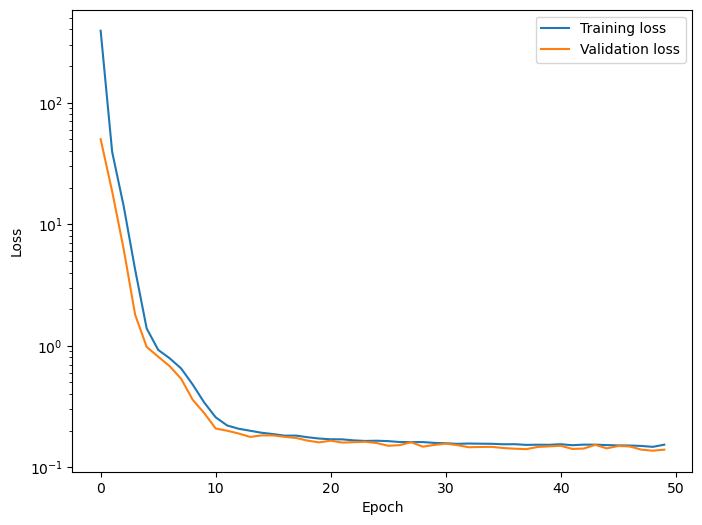

7/7 [==============================] - 0s 3ms/step


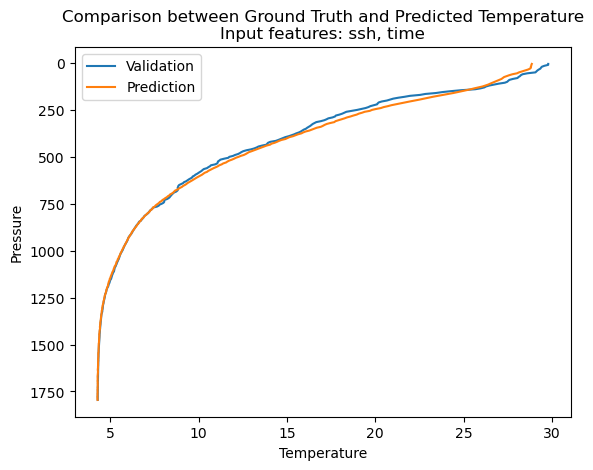

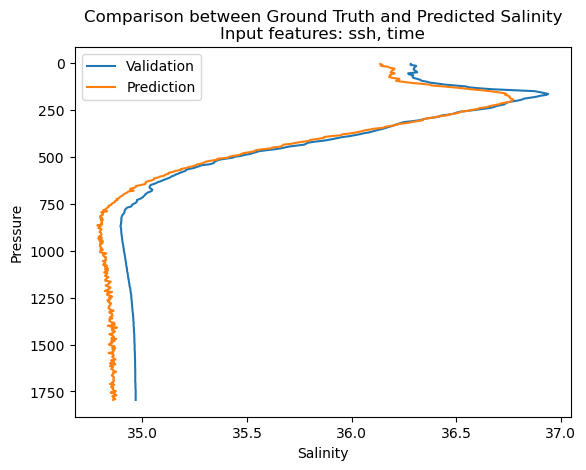

7/7 [==============================] - 0s 3ms/step - loss: 0.1396
MSE on validation set: 0.13964959979057312


In [9]:
## TO-DO: 
# fix title of plots (values are not correctly formatted)
# missing 

# Import necessary libraries
import numpy as np
import pandas as pd
import mat73
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import os

# Define the list of input features
# input_features = ['ssh', 'sst', 'time', 'lat', 'lon']
input_features = ['ssh', 'time']

# Load data from MATLAB files using mat73 library
ARGO = mat73.loadmat('ARGO_GoM_20220920.mat', use_attrdict=True)

# Display keys in the loaded ARGO data
print(ARGO.keys())

# Extract and display the relevant arrays from the ARGO variable
pres = np.arange(5, 1800, 5, dtype=int)  # index
sal = ARGO.SAL[pres, :]
temp = ARGO.TEMP[pres, :]
lat = ARGO.LAT
lon = ARGO.LON
ssh = ARGO.SH1950
time = ARGO.TIME

# Data cleaning: remove profiles with NaNs
nan_index = np.logical_or(np.isnan(sal).any(axis=0), np.isnan(temp).any(axis=0))
sal = sal[:, ~nan_index]
temp = temp[:, ~nan_index]
lat = lat[~nan_index]
lon = lon[~nan_index]
ssh = ssh[~nan_index]
time = time[~nan_index]

# Combine the input arrays into a single dataframe
df_X = pd.DataFrame({'ssh': ssh, 'sst': np.mean(temp[:1, :], axis=0), 'time': time, 'lat': lat, 'lon': lon})

# Select the columns corresponding to the input features
X = df_X[input_features].values

# Reshape the output arrays into a 2D array
y = np.column_stack((temp.T, sal.T))

# Define the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define the TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Find the indices of rows without NaN values
valid_idx = np.where(~np.isnan(X).any(axis=1))[0]

# Select a random subset of the valid rows
np.random.seed(42)
subset_idx = np.random.choice(valid_idx, size=2000, replace=False)

# Split the selected subset into training, validation, and testing sets
X_subset = X[subset_idx]
y_subset = y[subset_idx]
X_train, X_val_test, y_train, y_val_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Normalize the input data using z-score normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define the neural network architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation=None),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(y_train.shape[1], activation=None)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model with progress indicator
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[tensorboard_callback], verbose=2)

# Evaluate the model on test set
mse_test = model.evaluate(X_test, y_test)

# Use the model for predictions, get the first line of X
X_new = np.array([X[0,:]])
# X_new = np.array([[2.5, 20.0, 1000000, 41.0, -70.0]]) # example input
X_new = scaler.transform(X_new)
y_pred = model.predict(X_new)

# Save the model
model.save('model.h5')

# Plot the loss history during training
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate predictions on validation set
y_pred = model.predict(X_val)

# Plot comparison between predictions and ground truth for temperature
value = 0 # index of the selected profile
plt.plot(y_val[value, :359], pres, label='Validation')
plt.plot(y_pred[value, :359], pres, label='Prediction')
plt.title(f'Comparison between Ground Truth and Predicted Temperature\nInput features: {", ".join(input_features[:2])}')
plt.gca().invert_yaxis()
plt.ylabel('Pressure')
plt.xlabel('Temperature')
plt.legend()
plt.show()

# Plot comparison between predictions and ground truth for salinity
plt.plot(y_val[value, 359:], pres, label='Validation')
plt.plot(y_pred[value, 359:], pres, label='Prediction')
plt.title(f'Comparison between Ground Truth and Predicted Salinity\nInput features: {", ".join(input_features[:2])}')
plt.gca().invert_yaxis()
plt.ylabel('Pressure')
plt.xlabel('Salinity')
plt.legend()
plt.show()

# Calculate and print mean squared error on validation set
mse_val = model.evaluate(X_val, y_val)
print('MSE on validation set:', mse_val)

# Create a folder for saving figures, if it doesn't exist
if not os.path.exists('figures'):
    os.makedirs('figures')


In [10]:
# Define a function to plot the selected profile
def plot_profile(profile_idx):
    plt.clf()
    # Get the input values used for the prediction
    input_values = scaler.inverse_transform(X_val[profile_idx:profile_idx+1, :])[0]
    input_info = ", ".join([f"{input_features[i]}={input_values[i]:.2f}" for i in range(len(input_features))])

    lmt = int(y_val[profile_idx, :].size/2)
    
    # Mean squared error
    mse_t = np.mean((y_pred[profile_idx, :lmt] - y_val[profile_idx, :lmt])**2)
    mse_s = np.mean((y_pred[profile_idx, lmt:] - y_val[profile_idx, lmt:])**2)

    # Create the figure and subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    # Plot the temperature
    axs[0].plot(y_val[profile_idx, :lmt], pres, label='Validation')
    axs[0].plot(y_pred[profile_idx, :lmt], pres, label='Prediction')
    axs[0].set_title(f'Temperature \nMSE={mse_t:.4f}')
    axs[0].set_xlabel('Temperature (°C)')
    axs[0].set_ylabel('Pressure (dbar)')
    axs[0].legend()
    # Plot the salinity
    axs[1].plot(y_val[profile_idx, lmt:], pres, label='Validation')
    axs[1].plot(y_pred[profile_idx, lmt:], pres, label='Prediction')
    axs[1].set_title(f'Salinity \nMSE={mse_s:.4f}')
    axs[1].set_xlabel('Salinity (PSU)')
    axs[1].legend()
    axs[0].invert_yaxis()

    fig.suptitle(f'Profile {profile_idx+1}, {input_info}')

    # Save the figure
    iter_num = profile_idx + 1
    filename = f"figures/NN_GEM_{iter_num:03d}.jpg"
    plt.savefig(filename)
    # # Show the figure
    # plt.show()
    plt.clf()

# Loop over the 200 cases and create the plots
for i in range(200):
# Create and save the plot for the current profile
    plot_profile(i)
    plt.clf()

/tmp/ipykernel_45394/1228794716.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)


<Figure size 640x480 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [11]:
# Unix timestamp in seconds
timestamp = time[0]

# Convert Unix timestamp to datetime object
datetime_object = datetime.datetime.fromtimestamp(timestamp)

# Convert datetime object to Gregorian date string
date_string = datetime_object.strftime("%Y-%m-%d %H:%M:%S")

# Print the result
print(date_string)

1970-01-09 08:03:01
